In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

# Read dataset

In [198]:
import pickle as pkl
import json
import ast
np.set_printoptions(threshold=np.inf)
"""
param:path of folder
return :data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y
"""
def load_data(path = "DataSet/"):
    path_set = os.listdir(path)
    dataSet = []
    for filename in path_set:
        #read features of constraints 
        cons_file = open(path+filename+"/constraints_features.json","rb")
        data = json.load(cons_file)
        data_cons = np.array(data["values"])
        nb_cons = data_cons.shape[0]
        #read features of variables 
        var_file = open(path+filename+"/variables_features.json","rb")
        data = json.load(var_file)
        data_var = np.array(data["values"])
        nb_var = data_var.shape[0]
        #compose H
        data_cons = np.hstack((np.zeros((data_cons.shape[0],19)),data_cons))
        data_var = np.hstack((data_var,np.zeros((data_var.shape[0],5))))
        matrix_H = np.vstack((data_var,data_cons))
        
        #read label 
        label_file = open(path+filename+"/label.json","rb")
        data = json.load(label_file)
        bestSol = data["Best_Solution"]
        data_label = np.array(bestSol)

        #read edge
        edges_file = open(path+filename+"/edges_features.json","rb")
        data = json.load(edges_file)
        matrix_A = np.zeros((nb_cons+nb_var,nb_cons+nb_var))
        for i in range(len(data["values"])):
            iVar,iCons = data["indices"][1][i],data["indices"][0][i] 
            matrix_A[iVar][nb_var+iCons] = data["values"][i]
            matrix_A[iCons+nb_var][iVar] = data["values"][i]
        
        dataSet.append({"X":matrix_H,"Y":data_label,"A":matrix_A})
        
    return np.array(dataSet)
split = [0.70,0.15,0.15]
dataSet = load_data()
data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)


In [207]:
print(dataSet[0])
print(np.where(dataSet == nan))

{'X': array([[ 1.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  1.00000000e+000,  1.00000000e+000,
         3.49851584e-002, -0.00000000e+000, -0.00000000e+000,
         1.00000000e+000,  0.00000000e+000,  7.14285714e-002,
         0.00000000e+000,  6.61111298e-002,  1.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
                     nan,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],
       [ 1.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  1.00000000e+000,  1.00000000e+000,
         3.13126832e-002, -0.00000000e+000, -0.00000000e+000,
         1.00000000e+000,  0.00000000e+000,  7.14285714e-002,
         0.00000000e+000,  2.95147336e-004,  1.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000],


NameError: name 'nan' is not defined

# GCN






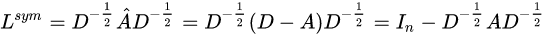

In [189]:
class MLP(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(MLP, self).__init__()
        self.linear = nn.Linear(in_channel, out_channel)
        self.activate = nn.ReLU()
        
    def forward(self, x, A):
        print("x before l",x[:,18])
        print(torch.where(x == float("inf")))
        x = self.linear(x)
#         x = torch.where(torch.isinf(x), torch.full_like(x, 0), x)
        print("x after l",x[:,0])
#         print("A",A[0])
        x = self.activate(x)
        print("xact",x.shape,x[:,1])
        print("A",A.shape,A[:,0])
        x = A.mm(x)       
        print("xmm",x[:,0])
        return x
    
class Net(nn.Module):
    def __init__(self, in_channel,aux_channel,out_channel):
        super(Net,self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            
            
            nn.ReLU(),
            nn.Linear(aux_channel, aux_channel),
        )
        self.mlp = MLP(in_channel, aux_channel)
        self.outlayer = nn.Sequential(
            nn.Linear(aux_channel, aux_channel),
            nn.ReLU(),
            nn.Linear(aux_channel, out_channel),
            nn.LogSoftmax()
#             nn.Sigmoid()
        )
    
    def forward(self, x, A,nb_net):
        x = self.mlp(x,A)
        for i in range(nb_net):
            x = self.layer(x)
        x = self.outlayer(x)
        return x

    

## Train


In [190]:
def train(model, x, y,A, optimizer,nb_net,criterion):
    model.zero_grad()
    size_y = len(y)
    output = model(x,A,nb_net)[:100].squeeze(dim=-1)
    print("output",output)
    loss =criterion(output,y)
    print("loss",loss)
    loss.backward()
    optimizer.step()

    return loss, output

In [191]:
device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")

net = Net(24,50,1)
# for name,param in net.named_parameters():
#     print(name,param)
nb_net = 1
EPOCHS = 2
optm = Adam(net.parameters(), lr = 0.001)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    for i in tqdm(range(1)):#len(data_train))):
        x_train, y_train = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_train[i]['A']).float()
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        loss, predictions = train(net,x_train,y_train,A,optm,nb_net, criterion)
        print(loss,predictions[0])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.13it/s]

x before l tensor([ 0.0000e+00,        -inf,  0.0000e+00, -0.0000e+00,  0.0000e+00,
         0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
                inf,        -inf,        -inf,  0.0000e+00,  0.0000e+00,
                inf,  0.0000e+00,         inf,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.7436e+09,         inf,        -inf,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -0.0000e+00,         inf,        -inf,
               -inf,         inf, -0.0000e+00, -0.0000e+00,  0.0000e+00,
         0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -1.1564e+20, -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -0.0000e+00,  0.0000e+00,  0.0000e+00,        -inf,  0.0000e+00,
         0.0000e+00, -0.0000e+00, -1.2070e+32,         inf,  0.0000e+00,
               -inf,  0.0000e+00,  0.0000e+00,  2.4539e+34,  0.0000e+00,
               -inf,        -inf,  0.000

In [104]:
# for parameters in net.parameters():
#     print(parameters)

In [144]:
print(loss,predictions)

tensor(nan, grad_fn=<BinaryCrossEntropyWithLogitsBackward>) tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan], grad_fn=<SqueezeBackward1>)
